In [111]:
# import necessary libraries
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.sparse.linalg import eigsh
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import multiprocessing as mp
from sklearn import metrics
import networkx as nx
import numpy as np
import random
import csv

In [112]:
%run ./functions_for_GrapHiC.ipynb

In [166]:
class DataGenerator():
    
    def __init__(self,
                 NumberOfClusters, LocPerCluster, r, IsolatedLoc,
                 SecondScale,
                 sigma_scramble = 1,
                 x_lim = [-100, 100], y_lim = [-100, 100],
                 cluster_shape = 'uniform'):
        
        # frame shape
        self.xmin, self.xmax = x_lim[0], x_lim[1]
        self.ymin, self.ymax = y_lim[0], y_lim[1]
        
        # parameters 
        self.NumberOfClusters = NumberOfClusters
        self.numbers          = LocPerCluster

        self.r                = r
        self.IsolatedLoc      = IsolatedLoc
        self.cluster_shape    = cluster_shape
        
        
        # data generation steps
        self.PlaceCenters()
        self.FillClusters()
        self.AddIsolatedLoc()
        self.Scramble(sigma_scramble)
        
    def PlaceCenters(self):
        
        # generating random centers of clusters, avoiding the frame edges
        
        # ------ version with no condition: ------
        # self.centers      = np.random.uniform(low=[self.xmin + self.rmax, self.ymin + self.rmax],
        #                                      high=[self.xmax-self.rmax, self.ymax-self.rmax],
        #                                      size=(self.NumberOfClusters,2))
        # ----------------------------------------
        
        # ------ Version with |ci - cj| < 2*rmax: ------
        self.centers      = np.random.uniform(low=[self.xmin + self.r, self.ymin + self.r],
                                              high=[self.xmax - self.r, self.ymax - self.r],
                                              size=(1,2))
        
        n = 1      # n counts the number of accepted points
        count = 0  # for avoiding endless loop
        while (n < self.NumberOfClusters) and (count < (self.NumberOfClusters * 10)): # 10 is arbitrarily chosen
            count += 1
            if (count  == ((self.NumberOfClusters * 10) -2) ): print('cannot place any more clusters')
            new_center = np.random.uniform(low=[self.xmin + self.r, self.ymin + self.r],
                                              high=[self.xmax-self.r, self.ymax-self.r],
                                              size=(1,2))
            is_accepted = True
            for i, c in enumerate(self.centers):
                if np.linalg.norm(c - new_center) < (2 * self.r): is_accepted = False
            
            if is_accepted: 
                n += 1
                self.centers = np.vstack([self.centers, new_center])
            
                 

    def FillClusters(self,):
        # Filling the clusters, each cluster i containing self.numbers[i] points. 
        np.random.seed(20)

        self.truelabels = []
        self.k          = 0

        points  = np.array([[0, 0]])  

        for i, center in enumerate(self.centers):
            if self.cluster_shape  == 'uniform':
                temp = uniform_cluster(self.r, self.numbers[i], center)
            elif self.cluster_shape == 'gaussian':
                temp = gaussian_cluster(self.r, self.numbers[i], center)
            else:
                print('cluster_shape must be "uniform" or "gaussian"')
                return # comment sortir tout court de la classe?
            
            self.truelabels = self.truelabels + [self.k for t in list(range(self.numbers[i]))]
            self.k          = self.k + 1
            for t in temp:
                points = np.append(points, [t], axis=0)

        points = points[1:] 
        self.points = points
        
        
    def AddIsolatedLoc(self):
        # n counts the number of isolated locations that are added to the data
        n = 0
        while n < self.IsolatedLoc:
            new_noise = np.random.uniform(low=[self.xmin, self.ymin], high=[self.xmax, self.ymax], size=(1,2))
            is_accepted = True 
            for i, c in enumerate(self.centers): # checking that it is not in a cluster
                if np.linalg.norm(c - new_noise) < (self.r): is_accepted = False 
            
            if is_accepted: 
                if n == 0: self.noise = new_noise
                else :     self.noise = np.vstack([self.noise, new_noise])
                    
                n += 1
            
        
        #noise      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(self.IsolatedLoc,2)) # old version, being on a cluster in accepted
        self.truelabels = self.truelabels + [self.k for t in  list(range(self.IsolatedLoc))] # labelling the isolated with same label
        # self.k          = self.k + 1
        for t in self.noise:
            self.points = np.append(self.points, [t], axis=0)
            
        self.points_obt = self.points # assign this name for users 
        
        
    def Scramble(self, sigma_scramble):
        mean = [0,0]
        cov_scramble = [[sigma_scramble**2, 0], [0, sigma_scramble**2]]
        # _obt stands for "obtained/collected data" 
        self.scrambled_points = np.array([np.sum([p, np.random.multivariate_normal(mean, cov_scramble)],
                                        axis = 0) for p in self.points])
        self.points_obt = self.scrambled_points
 
    #def Get_GT(self):
    #    return np.vstack([self.cluster_points, self.isolated_points])
        
    #def Get_Collected(self):
    #    return np.vstack([self.scrambled_cluster_points, self.isolated_points])

    def plot_GT(self):
        P1              = self.points 
        Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
        Sigma1[:, 0, 1] = 0
        Sigma1[:, 1, 0] = 0
        n1              = np.ones((P1.shape[0], 1)).ravel()
        self.truelabels = np.array(self.truelabels)

        plot_points(P1, self.truelabels, 'Input Data: GT', 4)
        plot_points(P1, self.truelabels * 0, 'Input Data', 4)
        
    def plot_collected(self):
        P1              = self.points_obt 
        Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
        Sigma1[:, 0, 1] = 0
        Sigma1[:, 1, 0] = 0
        n1              = np.ones((P1.shape[0], 1)).ravel()
        self.truelabels = np.array(self.truelabels)

        plot_points(P1, self.truelabels, 'Input Data: GT', 4)
        plot_points(P1, self.truelabels * 0, 'Input Data', 4)
        
        
        

In [167]:
# Region of interest : 
x_lim = [-150, 50]
y_lim = [-50, 150]


# Clusters :

NumberOfClusters = 20
LocPerCluster    = [100] * NumberOfClusters 

r                = 3
IsolatedLoc      = 100
sigma_scramble   = 1.2

SecondScale      = True
#r2min = 20
#r2max = 22
#IsolatedClusters = 0 # voir ici comment faire ça de manière bien compréhensible 


# Generating the data :

datagen = DataGenerator(x_lim = x_lim,
                        y_lim = y_lim,
                        NumberOfClusters = NumberOfClusters,
                        LocPerCluster = LocPerCluster,
                        r = r,
                        IsolatedLoc = IsolatedLoc,
                        SecondScale = SecondScale,
                        sigma_scramble = sigma_scramble, cluster_shape = 'uniform') 

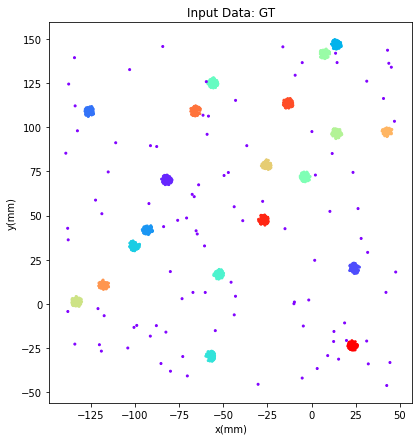

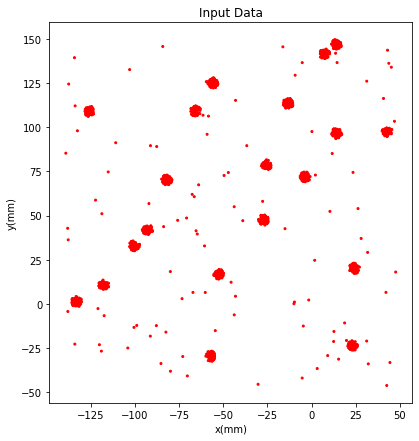

In [168]:
datagen.plot_GT()

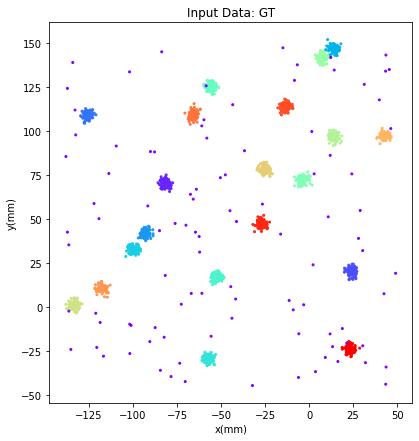

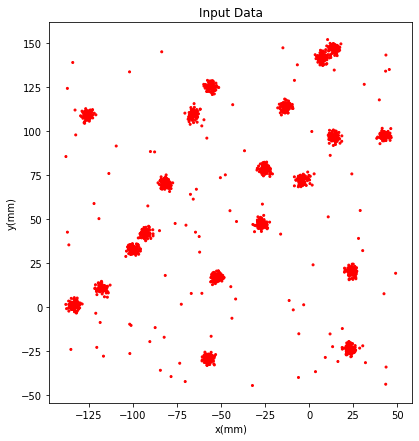

In [169]:
datagen.plot_collected()

In [170]:
datagen.default_value

AttributeError: 'DataGenerator' object has no attribute 'default_value'

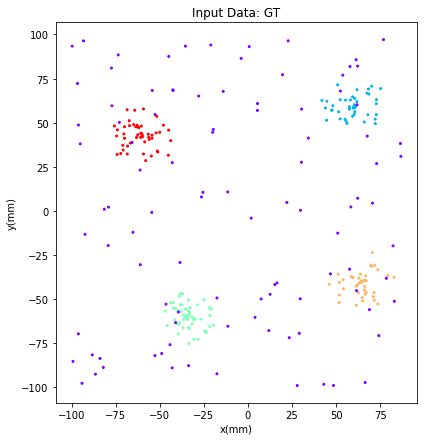

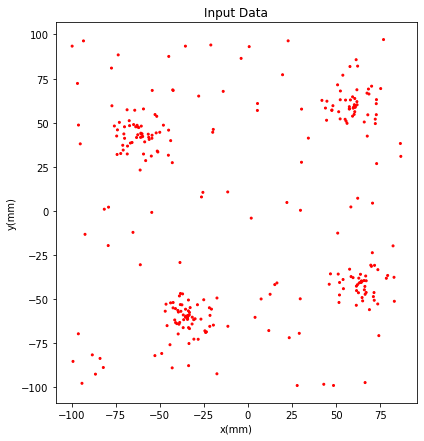

In [171]:
def give_circle_points(rmin, rmax, n_points, center):
    # This function generates "n_points" uniform points inside a circle with center of "center", 
    # and a random radius between "r_min" and "rmax"
    r         = np.random.uniform(rmin, rmax, 1)
    r_s       = np.random.uniform(0, r, n_points)
    theta_s   = np.random.uniform(0, np.pi*2, n_points)
    sin_theta = np.sin(theta_s)
    cos_theta = np.cos(theta_s)
    points    = [[center[0] + r_s[i] * cos_theta[i], center[1] + r_s[i] * sin_theta[i]] for i in range(n_points)]  
    return points


np.random.seed(10)


truelabels = []
k          = 0

centers = [(-60, 42), (65, -40), (-35, -60), (60, 60)]
points  = np.array([[0, 0]])
numbers = [50, 40, 55, 45]  

for i, center in enumerate(centers):
    temp = give_circle_points(16, 20, numbers[i], center)
    truelabels = truelabels + [k for t in list(range(numbers[i]))]
    k          = k + 1
    for t in temp:
        points = np.append(points, [t], axis=0)

points = points[1:]  


noise      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(100,2))
truelabels = truelabels + [k for t in  list(range(100))]
k          = k + 1
for t in noise:
    points = np.append(points, [t], axis=0)

P1              = points 
Sigma1          = np.ones((P1.shape[0], 2, 2)) * 0.5
Sigma1[:, 0, 1] = 0
Sigma1[:, 1, 0] = 0
n1              = np.ones((P1.shape[0], 1)).ravel()
truelabels      = np.array(truelabels)




plot_points(P1, truelabels, 'Input Data: GT', 4)
plot_points(P1, truelabels * 0, 'Input Data', 4)

In [90]:
NbOfCenters       = 10
centres_test      = np.random.uniform(low=[-100, -100], high=[100, 100], size=(10,2))

In [91]:
centres_test

array([[ 51.84778798, -35.52984434],
       [  0.40442902,  16.76621306],
       [-46.67982349,  42.76932891],
       [ -8.54577859,  30.04627448],
       [  0.5337677 , -13.72128692],
       [ 43.55329222, -97.52783149],
       [-83.94112499,  15.27458907],
       [ 62.72434329,  12.30724673],
       [ 20.71833923, -55.88383496],
       [ 83.90820852, -58.89985992]])

In [92]:
type(centres_test)

numpy.ndarray

In [88]:
centres_test.shape

(10, 2)

In [89]:
centres_test = np.append(centres_test, np.array([[1,1]]))

TypeError: 'list' object cannot be interpreted as an integer

In [79]:
centres_test

array([ 83.65925948,  96.92436924,  99.409429  ,   3.18479213,
        40.01686172, -84.68824496,  80.22829935,  62.71652942,
       -28.18765735,  95.14074742, -22.8027806 , -96.7581216 ,
       -96.26510893,   8.82790867, -11.37073655, -94.85997051,
       -26.33909709, -15.93589842, -18.91920775,  99.61553293,
         1.        ,   1.        ])

In [80]:
centres_test.shape

(22,)

In [82]:
type(centres_test)

numpy.ndarray

In [74]:
np.array([[1,1]]).shape

(1, 2)

In [93]:
newrow = [1,1]

In [97]:
centres_test = np.vstack([centres_test, newrow])

In [98]:
centres_test

array([[ 51.84778798, -35.52984434],
       [  0.40442902,  16.76621306],
       [-46.67982349,  42.76932891],
       [ -8.54577859,  30.04627448],
       [  0.5337677 , -13.72128692],
       [ 43.55329222, -97.52783149],
       [-83.94112499,  15.27458907],
       [ 62.72434329,  12.30724673],
       [ 20.71833923, -55.88383496],
       [ 83.90820852, -58.89985992],
       [  1.        ,   1.        ]])

In [118]:
N = [40] * 5 + [50] * 10

In [119]:
N

[40, 40, 40, 40, 40, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [52]:
datagen.points

array([[-68.15390535,  15.21904901],
       [-79.21399243,  14.83451655],
       [-71.4504602 ,  21.90008897],
       ...,
       [ -9.86909978,  79.88750167],
       [ 59.12631972, -77.14514175],
       [  3.6167897 ,  75.65768656]])

In [63]:
scramble_points = [np.sum([p, [1,1]], axis = 0) for p in datagen.points]

In [64]:
scramble_points

[array([-67.15390535,  16.21904901]),
 array([-78.21399243,  15.83451655]),
 array([-70.4504602 ,  22.90008897]),
 array([-72.7461479 ,  17.81992862]),
 array([-77.32832206,  18.27254728]),
 array([-74.46959017,  16.22244216]),
 array([-70.95486754,  15.16446305]),
 array([-76.98159278,  19.10500899]),
 array([-74.05315726,  18.07099132]),
 array([-73.54602666,  16.43398926]),
 array([-75.53994058,  14.21066296]),
 array([-73.38392994,  23.17706333]),
 array([-67.66787238,  20.35416824]),
 array([-72.09004184,  12.99334221]),
 array([-73.01598082,  18.083254  ]),
 array([-73.14315893,  18.7299996 ]),
 array([-77.71463051,  17.72378416]),
 array([-72.91094559,  19.62468835]),
 array([-73.39913612,  19.61327941]),
 array([-76.72461582,  14.01294867]),
 array([21.70161418, 82.61060563]),
 array([20.3624414 , 82.85024676]),
 array([22.53913377, 82.96185334]),
 array([18.55054054, 85.59096897]),
 array([21.47333238, 85.3542277 ]),
 array([21.22454273, 88.4148952 ]),
 array([17.17609837, 82.

In [51]:
mean = [0, 0]
cov = [[0.01, 0], [0, 0.01]]
np.random.multivariate_normal(mean, cov)

array([-0.11988111,  0.14169898])

In [123]:
xlimit = [-50, 50]
xlimit[0]

-50

In [147]:
x = 4

if x == 3: 
    print(3)
elif x == 5:
    print(5)
else: 
    print('x doit etre "trois" ou "cinq"')

x doit etre "trois" ou "cinq"
